In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
tf.config.list_physical_devices('GPU')

[]

In [7]:
import zipfile
import os

# Set paths
zip_path = r'C:\Users\SRINIVAS\Downloads\brain-mri-images-for-brain-tumor-detection.zip'
extract_to = r'C:\Users\SRINIVAS\Downloads\Tumour'

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("✅ Extraction complete!")


✅ Extraction complete!


In [14]:
train_dir = r'C:\Users\SRINIVAS\Downloads\Tumour\data\Tumour\train'
val_dir = r'C:\Users\SRINIVAS\Downloads\Tumour\data\Tumour\valid'
test_dir = r'C:\Users\SRINIVAS\Downloads\Tumour\data\Tumour\test'


In [15]:
# Training data generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to [0, 1]

    # Data augmentation parameters
    rotation_range=20,  # Random rotation between -20 and +20 degrees
    width_shift_range=0.2,  # Random horizontal shift by ±20% of width
    height_shift_range=0.2,  # Random vertical shift by ±20% of height
    zoom_range=0.2,  # Random zoom between 80% and 120%
    horizontal_flip=True,  # Random horizontal flipping
    vertical_flip=False,  # No vertical flipping (can enable if appropriate)
    fill_mode='nearest'  # Strategy for filling in newly created pixels
)

# Validation and test generators (only rescaling, no augmentation)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [16]:
# Set image size and batch size
img_width, img_height = 224, 224  # Adjust as needed
batch_size = 32  # Adjust as needed

# Create data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'  # or 'binary' if you have two classes
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Important for evaluating the test set
)

Found 1695 images belonging to 4 classes.
Found 502 images belonging to 4 classes.
Found 246 images belonging to 4 classes.


In [17]:
class_names = list(train_generator.class_indices.keys())
num_classes = len(class_names)
print(f"Class names: {class_names}")
print(f"Number of classes: {num_classes}")

Class names: ['glioma', 'meningioma', 'no_tumor', 'pituitary']
Number of classes: 4


In [18]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

c:\Users\SRINIVAS\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [19]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy',
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall')])

# Model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,476 (42.61 MB)

 Trainable params: 11,169,476 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
epochs = 10
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

c:\Users\SRINIVAS\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.3801 - loss: 1.3750 - precision: 0.4484 - recall: 0.1200 - val_accuracy: 0.5708 - val_loss: 0.9920 - val_precision: 0.7684 - val_recall: 0.3042
Epoch 2/10
 1/52 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.6250 - loss: 0.9945 - precision: 0.8571 - recall: 0.1875

c:\Users\SRINIVAS\anaconda3\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 92ms/step - accuracy: 0.6250 - loss: 0.9945 - precision: 0.8571 - recall: 0.1875 - val_accuracy: 0.5729 - val_loss: 0.9839 - val_precision: 0.7488 - val_recall: 0.3292
Epoch 3/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.5714 - loss: 1.0346 - precision: 0.6964 - recall: 0.3575 - val_accuracy: 0.5875 - val_loss: 0.9746 - val_precision: 0.7077 - val_recall: 0.4187
Epoch 4/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - accuracy: 0.7188 - loss: 0.8202 - precision: 0.8947 - recall: 0.5312 - val_accuracy: 0.5312 - val_loss: 1.1480 - val_precision: 0.6325 - val_recall: 0.3729
Epoch 5/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.6616 - loss: 0.8765 - precision: 0.7361 - recall: 0.5271 - val_accuracy: 0.7000 - val_loss: 0.7957 - val_precision: 0.7603 - val_recall: 0.5750
Epoch 6/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - accuracy: 0.5625 - loss: 0.8944 - precision: 0.7619 - recall: 0.5000 - val_accuracy: 0.7000 - val_loss: 0.7787 - val_precisi

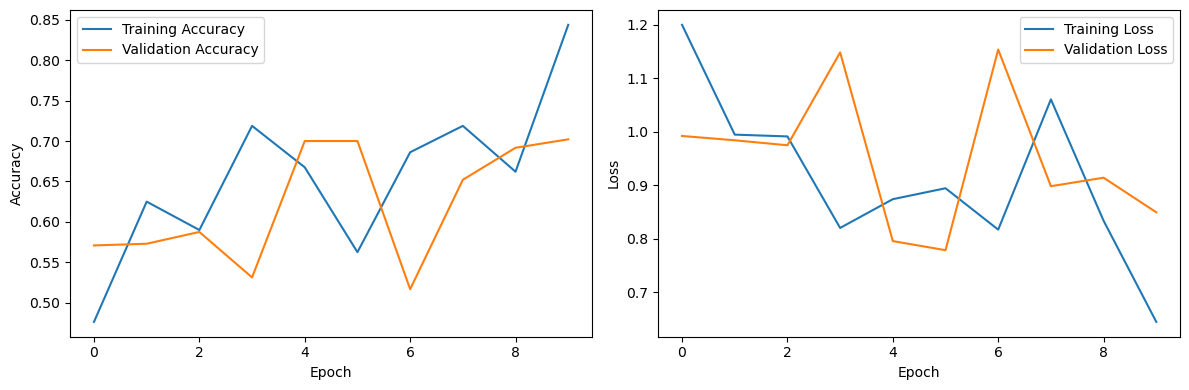

In [21]:
def plot_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)

In [22]:
test_loss, test_acc, test_precision, test_recall = model.evaluate(test_generator)
print(f'\nTest accuracy: {test_acc:.4f}')
print(f'Test precision: {test_precision:.4f}')
print(f'Test recall: {test_recall:.4f}')

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 360ms/step - accuracy: 0.6815 - loss: 0.9796 - precision: 0.7558 - recall: 0.4935

Test accuracy: 0.7114
Test precision: 0.7717
Test recall: 0.5772


In [23]:
test_generator.reset()
predictions = model.predict(test_generator, steps=test_generator.samples // batch_size + 1)
predicted_classes = np.argmax(predictions, axis=1)

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 325ms/step


In [24]:
true_classes = test_generator.classes

In [25]:
print('\nClassification Report:')
print(classification_report(true_classes, predicted_classes, target_names=class_names))

# Confusion matrix
conf_mat = confusion_matrix(true_classes, predicted_classes)
print('\nConfusion Matrix:')
print(conf_mat)


Classification Report:
              precision    recall  f1-score   support

      glioma       0.91      0.79      0.85        80
  meningioma       0.84      0.25      0.39        63
    no_tumor       0.54      0.92      0.68        49
   pituitary       0.69      0.94      0.80        54

    accuracy                           0.71       246
   macro avg       0.75      0.73      0.68       246
weighted avg       0.77      0.71      0.68       246


Confusion Matrix:
[[63  3  7  7]
 [ 4 16 29 14]
 [ 2  0 45  2]
 [ 0  0  3 51]]


In [26]:
from tensorflow.keras.applications import (VGG16, ResNet50, MobileNet,
                                          InceptionV3, EfficientNetB0)
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

model_comparison = []

1. VGG16

In [27]:
def evaluate_vgg16():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False

    model = tf.keras.Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(0.001),
                 loss='categorical_crossentropy',
                 metrics=['accuracy',
                         tf.keras.metrics.Precision(name='precision'),
                         tf.keras.metrics.Recall(name='recall')])

    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=10,
        callbacks=[EarlyStopping(patience=3)]
    )

    return model, history

vgg_model, vgg_history = evaluate_vgg16()
model_comparison.append({
    'Model': 'VGG16',
    'Val Accuracy': max(vgg_history.history['val_accuracy']),
    'Val Precision': max(vgg_history.history['val_precision']),
    'Val Recall': max(vgg_history.history['val_recall']),
    'Parameters': f"{vgg_model.count_params():,}",
    'Inference Time': 'Medium',
    'Best For': 'Medium-sized datasets'
})

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step
Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 359s 7s/step - accuracy: 0.2899 - loss: 1.4588 - precision: 0.3097 - recall: 0.0283 - val_accuracy: 0.5100 - val_loss: 1.2271 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 345s 7s/step - accuracy: 0.4955 - loss: 1.2229 - precision: 0.9279 - recall: 0.0714 - val_accuracy: 0.5757 - val_loss: 1.1049 - val_precision: 0.8704 - val_recall: 0.1873
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 347s 7s/step - accuracy: 0.5588 - loss: 1.1075 - precision: 0.8249 - recall: 0.1903 - val_accuracy: 0.6414 - val_loss: 1.0248 - val_precision: 0.8116 - val_recall: 0.2231
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 357s 7s/step - accuracy: 0.6218 - loss: 1.0282 - precision: 0.8380 - recall: 0.2484 - val_accuracy: 0.6474 - val_loss: 0.9764 - val_precision: 0.8095 - val_recall: 0.3048
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 402s 8s/step - accuracy: 0.6500 - loss: 0.9656 - precision: 0.8312 

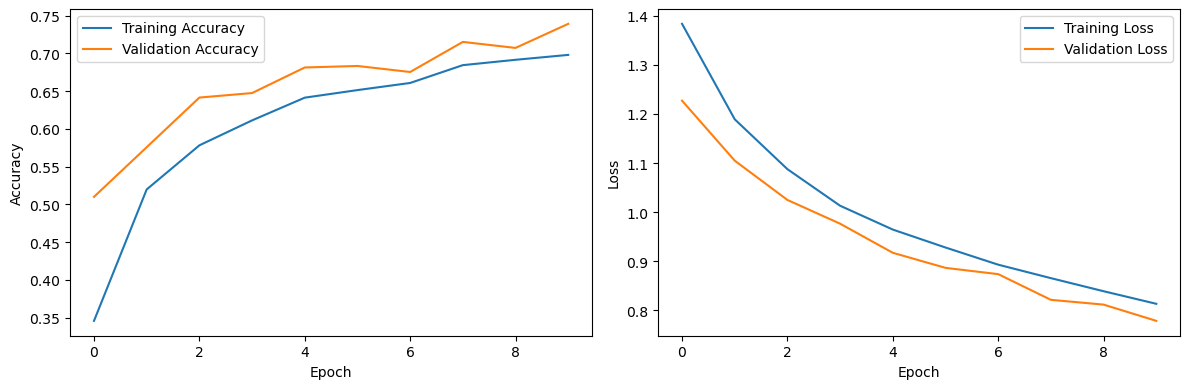

8/8 ━━━━━━━━━━━━━━━━━━━━ 76s 10s/step - accuracy: 0.7400 - loss: 0.7225 - precision: 0.8913 - recall: 0.5596

Test accuracy: 0.7317
Test precision: 0.8803
Test recall: 0.5081
8/8 ━━━━━━━━━━━━━━━━━━━━ 73s 9s/step


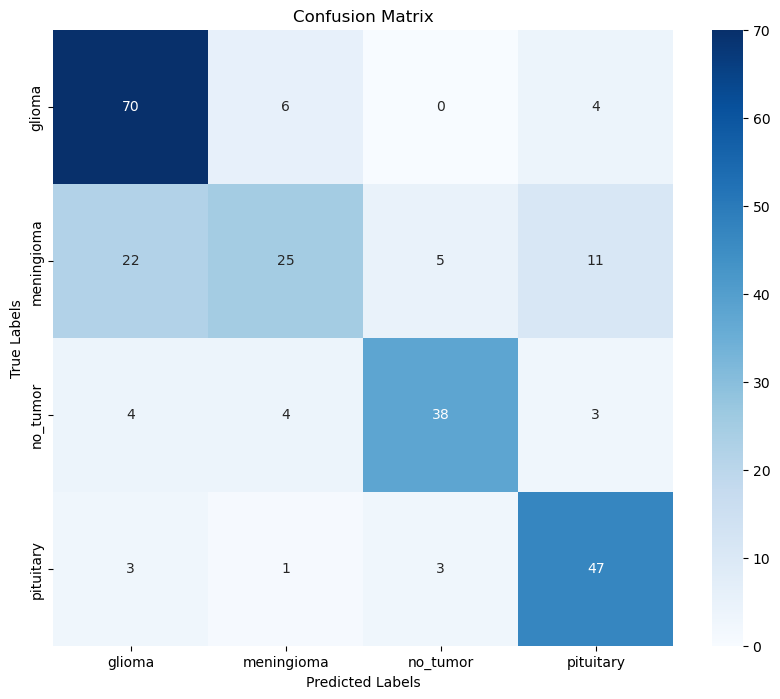

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


def plot_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(vgg_history)


# Evaluate on test set (assuming you have a test_generator)
test_generator.reset() # Reset the generator before evaluating
test_loss, test_acc, test_precision, test_recall = vgg_model.evaluate(test_generator)
print(f'\nTest accuracy: {test_acc:.4f}')
print(f'Test precision: {test_precision:.4f}')
print(f'Test recall: {test_recall:.4f}')


# Generate predictions
predictions = vgg_model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Get true classes
true_classes = test_generator.classes

# Confusion Matrix
conf_mat = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()  

2. RESNET50

In [29]:
def evaluate_resnet50():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False

    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = tf.keras.applications.resnet50.preprocess_input(inputs)
    x = base_model(x, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.2)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(0.001),
                 loss='categorical_crossentropy',
                 metrics=['accuracy', 'precision', 'recall'])

    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=10,
        callbacks=[EarlyStopping(patience=3)]
    )

    return model, history

resnet_model, resnet_history = evaluate_resnet50()
model_comparison.append({
    'Model': 'ResNet50',
    'Val Accuracy': max(resnet_history.history['val_accuracy']),
    'Val Precision': max(resnet_history.history['val_precision']),
    'Val Recall': max(resnet_history.history['val_recall']),
    'Parameters': f"{resnet_model.count_params():,}",
    'Inference Time': 'Medium',
    'Best For': 'General purpose'
})

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 122s 1us/step
Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 222s 4s/step - accuracy: 0.3031 - loss: 1.4900 - precision: 0.3367 - recall: 0.0533 - val_accuracy: 0.5040 - val_loss: 1.2786 - val_precision: 0.8077 - val_recall: 0.0418
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 216s 4s/step - accuracy: 0.3787 - loss: 1.2976 - precision: 0.7801 - recall: 0.0477 - val_accuracy: 0.5000 - val_loss: 1.2216 - val_precision: 0.7857 - val_recall: 0.0438
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 218s 4s/step - accuracy: 0.3933 - loss: 1.2849 - precision: 0.6683 - recall: 0.0534 - val_accuracy: 0.4940 - val_loss: 1.2291 - val_precision: 0.8113 - val_recall: 0.0857
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 201s 4s/step - accuracy: 0.4427 - loss: 1.2401 - precision: 0.7173 - recall: 0.0806 - val_accuracy: 0.5936 - val_loss: 1.1749 - val_precision: 0.8333 - val_recall: 0.0598
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 202s 4s/step - accuracy: 0.4554 - loss: 1.2310 - precision: 0.6887 - reca

3. MobileNet

In [30]:
def evaluate_mobilenet():
    base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False

    model = tf.keras.Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(0.001),
                 loss='categorical_crossentropy',
                 metrics=['accuracy', 'precision', 'recall'])

    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=10,
        callbacks=[EarlyStopping(patience=3)]
    )

    return model, history

mobilenet_model, mobilenet_history = evaluate_mobilenet()
model_comparison.append({
    'Model': 'MobileNet',
    'Val Accuracy': max(mobilenet_history.history['val_accuracy']),
    'Val Precision': max(mobilenet_history.history['val_precision']),
    'Val Recall': max(mobilenet_history.history['val_recall']),
    'Parameters': f"{mobilenet_model.count_params():,}",
    'Inference Time': 'Fast',
    'Best For': 'Mobile/Edge devices'
})

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 19s 1us/step
Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.3912 - loss: 1.4121 - precision: 0.4464 - recall: 0.2549 - val_accuracy: 0.7809 - val_loss: 0.5961 - val_precision: 0.8381 - val_recall: 0.7012
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.7804 - loss: 0.5881 - precision: 0.8350 - recall: 0.6985 - val_accuracy: 0.7928 - val_loss: 0.5086 - val_precision: 0.8300 - val_recall: 0.7490
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.8201 - loss: 0.4913 - precision: 0.8687 - recall: 0.7619 - val_accuracy: 0.8745 - val_loss: 0.3937 - val_precision: 0.9013 - val_recall: 0.8367
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.8352 - loss: 0.4226 - precision: 0.8751 - recall: 0.7840 - val_accuracy: 0.8625 - val_loss: 0.3891 - val_precision: 0.8979 - val_recall: 0.8406
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.8493 - loss: 0.3630 - precision: 0.8790 - recall: 0.

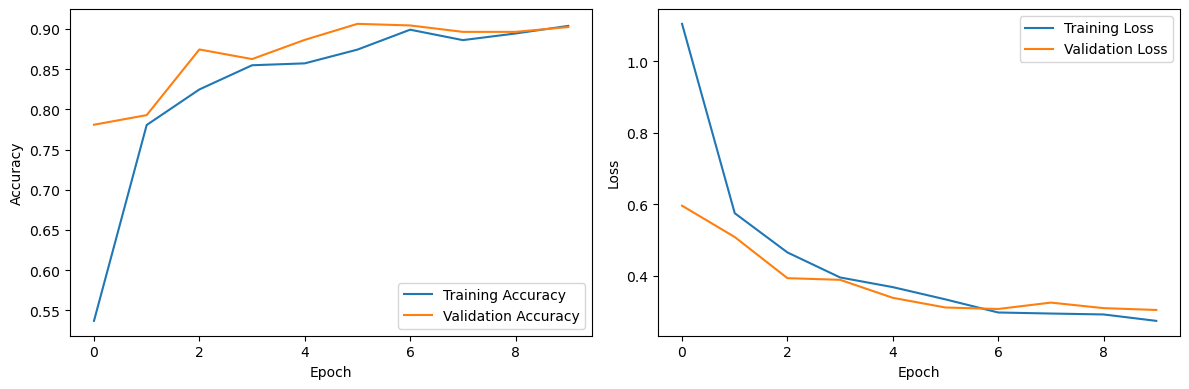

In [31]:
plot_history(mobilenet_history)

8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.9045 - loss: 0.2817 - precision: 0.9141 - recall: 0.8848

MobileNet Test accuracy: 0.8943
MobileNet Test precision: 0.9076
MobileNet Test recall: 0.8780
8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step


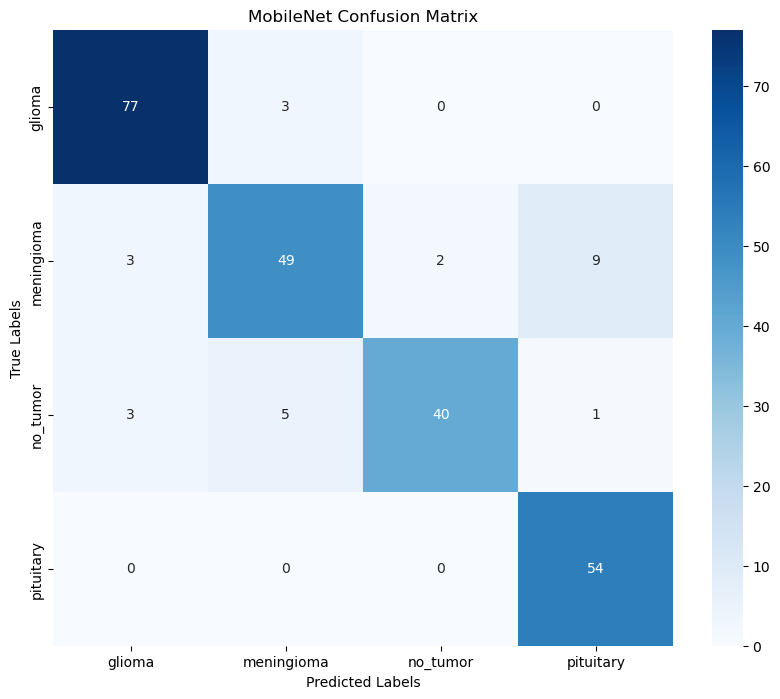

In [32]:
test_generator.reset()  # Reset the generator before evaluating
test_loss, test_acc, test_precision, test_recall = mobilenet_model.evaluate(test_generator)
print(f'\nMobileNet Test accuracy: {test_acc:.4f}')
print(f'MobileNet Test precision: {test_precision:.4f}')
print(f'MobileNet Test recall: {test_recall:.4f}')

# Generate predictions for MobileNet
predictions = mobilenet_model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Get true classes for MobileNet
true_classes = test_generator.classes

# Confusion Matrix for MobileNet
conf_mat = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix for MobileNet using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('MobileNet Confusion Matrix')
plt.show()

4.InceptionV3

In [33]:
def evaluate_inception():
    # Special generator for Inception's 299x299 input
    inception_train_gen = train_datagen.flow_from_directory(
        train_dir, target_size=(299, 299), batch_size=batch_size)
    inception_val_gen = val_datagen.flow_from_directory(
        val_dir, target_size=(299, 299), batch_size=batch_size)

    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
    base_model.trainable = False

    inputs = tf.keras.Input(shape=(299, 299, 3))
    x = tf.keras.applications.inception_v3.preprocess_input(inputs)
    x = base_model(x, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.2)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(0.001),
                 loss='categorical_crossentropy',
                 metrics=['accuracy', 'precision', 'recall'])

    history = model.fit(
        inception_train_gen,
        validation_data=inception_val_gen,
        epochs=10,
        callbacks=[EarlyStopping(patience=3)]
    )

    return model, history

inception_model, inception_history = evaluate_inception()
model_comparison.append({
    'Model': 'InceptionV3',
    'Val Accuracy': max(inception_history.history['val_accuracy']),
    'Val Precision': max(inception_history.history['val_precision']),
    'Val Recall': max(inception_history.history['val_recall']),
    'Parameters': f"{inception_model.count_params():,}",
    'Inference Time': 'Medium',
    'Best For': 'Multi-scale features'
})

Found 1695 images belonging to 4 classes.
Found 502 images belonging to 4 classes.
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 88s 1us/step


c:\Users\SRINIVAS\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 250s 5s/step - accuracy: 0.3520 - loss: 1.3307 - precision: 0.5405 - recall: 0.0408 - val_accuracy: 0.3665 - val_loss: 1.2705 - val_precision: 0.6346 - val_recall: 0.1315
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 223s 4s/step - accuracy: 0.4408 - loss: 1.2159 - precision: 0.7363 - recall: 0.1338 - val_accuracy: 0.5777 - val_loss: 1.1284 - val_precision: 0.6875 - val_recall: 0.1096
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 222s 4s/step - accuracy: 0.4991 - loss: 1.1858 - precision: 0.7269 - recall: 0.1373 - val_accuracy: 0.5817 - val_loss: 1.0711 - val_precision: 0.8085 - val_recall: 0.2271
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 220s 4s/step - accuracy: 0.5204 - loss: 1.1595 - precision: 0.7169 - recall: 0.2286 - val_accuracy: 0.5478 - val_loss: 1.1027 - val_precision: 0.6812 - val_recall: 0.2809
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 219s 4s/step - accuracy: 0.5560 - loss: 1.1151 - precision: 0.7463 - recall: 0.2410 - val_accuracy: 0.6215 - val_loss: 1.0497 

5. EfficientNet

In [34]:
def evaluate_efficientnet():
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False

    model = tf.keras.Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(0.001),
                 loss='categorical_crossentropy',
                 metrics=['accuracy', 'precision', 'recall'])

    history = model.fit(
        train_generator,
        validation_data= validation_generator,
        epochs=10,
        callbacks=[EarlyStopping(patience=3)]
    )

    return model, history

efficientnet_model, efficientnet_history = evaluate_efficientnet()
model_comparison.append({
    'Model': 'EfficientNetB0',
    'Val Accuracy': max(efficientnet_history.history['val_accuracy']),
    'Val Precision': max(efficientnet_history.history['val_precision']),
    'Val Recall': max(efficientnet_history.history['val_recall']),
    'Parameters': f"{efficientnet_model.count_params():,}",
    'Inference Time': 'Fast',
    'Best For': 'Best accuracy/efficiency tradeoff'
})

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 10s 1us/step
Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 121s 2s/step - accuracy: 0.2905 - loss: 1.3832 - precision: 0.1581 - recall: 0.0021 - val_accuracy: 0.2351 - val_loss: 1.3842 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.2956 - loss: 1.3788 - precision: 0.1263 - recall: 6.5526e-04 - val_accuracy: 0.2351 - val_loss: 1.3915 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 114s 2s/step - accuracy: 0.3133 - loss: 1.3807 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.3207 - val_loss: 1.3705 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 167s 3s/step - accuracy: 0.3129 - loss: 1.3754 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.2351 - val_loss: 1.3998 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 113s 2s/step - accuracy

Models comparison

In [35]:
import pandas as pd
comparison_df = pd.DataFrame(model_comparison)
comparison_df = comparison_df.sort_values('Val Accuracy', ascending=False)
comparison_df.style.background_gradient(cmap='Blues', subset=['Val Accuracy', 'Val Precision', 'Val Recall'])

,Model,Val Accuracy,Val Precision,Val Recall,Parameters,Inference Time,Best For
2,MobileNet,0.906375,0.917695,0.898406,"3,232,964",Fast,Mobile/Edge devices
0,VGG16,0.739044,0.870370,0.448207,"14,716,740",Medium,Medium-sized datasets
3,InceptionV3,0.639442,0.808511,0.454183,"21,810,980",Medium,Multi-scale features
1,ResNet50,0.631474,0.854167,0.177291,"23,595,908",Medium,General purpose
4,EfficientNetB0,0.320717,0.000000,0.000000,"4,054,695",Fast,Best accuracy/efficiency tradeoff


In [37]:
comparison_df.to_csv(r'C:\Users\SRINIVAS\Downloads\model_comparison.csv', index=False)

In [39]:
import pandas as pd
df=pd.read_csv(r'C:\Users\SRINIVAS\Downloads\model_comparison.csv')
df

,Model,Val Accuracy,Val Precision,Val Recall,Parameters,Inference Time,Best For
0,MobileNet,0.906375,0.917695,0.898406,"3,232,964",Fast,Mobile/Edge devices
1,VGG16,0.739044,0.870370,0.448207,"14,716,740",Medium,Medium-sized datasets
2,InceptionV3,0.639442,0.808511,0.454183,"21,810,980",Medium,Multi-scale features
3,ResNet50,0.631474,0.854167,0.177291,"23,595,908",Medium,General purpose
4,EfficientNetB0,0.320717,0.000000,0.000000,"4,054,695",Fast,Best accuracy/efficiency tradeoff


The best performing model is:
Model                       MobileNet
Val Accuracy                 0.906375
Val Precision                0.917695
Val Recall                   0.898406
Parameters                  3,232,964
Inference Time                   Fast
Best For          Mobile/Edge devices
Name: 0, dtype: object


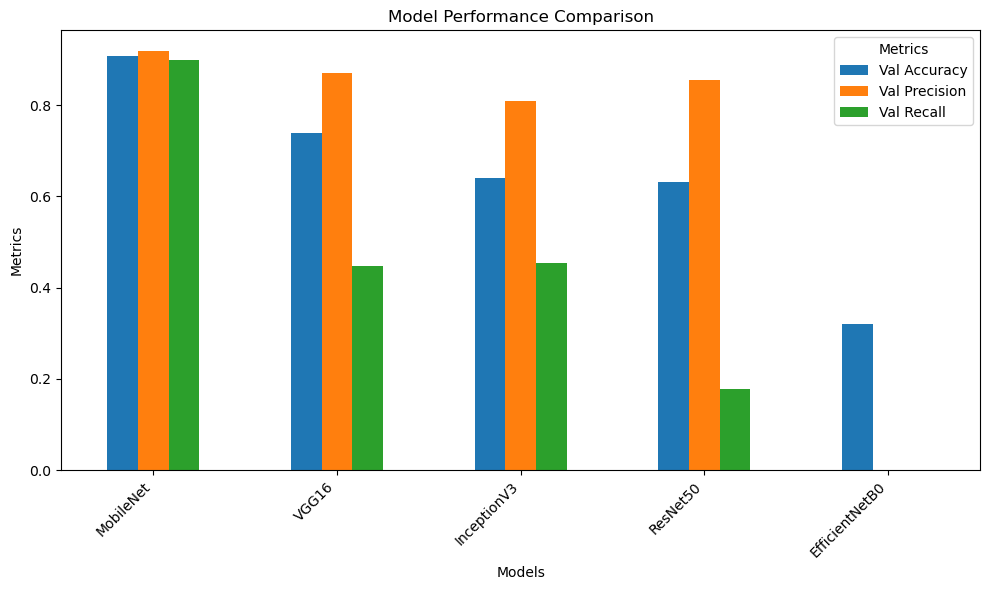

In [40]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv(r'C:\Users\SRINIVAS\Downloads\model_comparison.csv')


# Find the best model based on validation accuracy
best_model = df.loc[df['Val Accuracy'].idxmax()]

print(f"The best performing model is:\n{best_model}")

# Plotting the bar chart
plt.figure(figsize=(10, 6))
df.plot(x='Model', y=['Val Accuracy', 'Val Precision', 'Val Recall'], kind='bar', ax=plt.gca())
plt.title('Model Performance Comparison')
plt.ylabel('Metrics')
plt.xlabel('Models')


plt.xticks(rotation=45, ha='right')
plt.legend(title='Metrics')
plt.tight_layout()
plt.show()

In [43]:
mobilenet_model.save(r'C:\Users\SRINIVAS\Downloads\model.h5')

In [44]:
!pip install streamlit numpy pillow tensorflow